# Purpose

This notebook creates a detection/classification Convolutional Neural Network (CNN) that determines whether or not a weapon (pistol or rifle) is within a given input image.

$\newline$
**Resources**
* Weapons Dataset: https://github.com/HeeebsInc/NN_Weapon_Detection
$\newline$
* Image Classification Outline (from a previous semester): https://medium.com/@kylepob61392/airplane-image-classification-using-a-keras-cnn-22be506fdb53

In [1]:
# Imports
import imageio, glob

import numpy as np
import os.path as path
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

### Get Images from Dataset

In [2]:
LOCATION = 'C:/Users/jbmut/AI Projects/Kaggle Work/Computer_Vision_Tutorial/Detect_Guns/'
file_paths = glob.glob(path.join(LOCATION, '*.png'))

# Load the images
images = [imageio.imread(i_path) for i_path in file_paths]
images = np.asarray(images)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

[96 96  3]


### Scale Images & Create Train/Test Datasets

In [3]:
# Scale the images
images = images / 255

# Read the labels from the filenames
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

# Utilize 90/10 Training/Testing Split
TRAIN_TEST_SPLIT = 0.90

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
X_train = images[train_indices, :, :, :]
X_test = images[test_indices, :, :, :]

Y_train = labels[train_indices]
Y_test = labels[test_indices]

### Visualize Data
* 0 = No Weapon Detected Within Image Frame
    - Image is classified as not having a weapon contained within it
$\newline$
* 1 = Weapon Detected within Image Frame
    - Image is classified as having a weapon contained within it

In [ ]:
def visualize_data(positive_images, negative_images):
    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

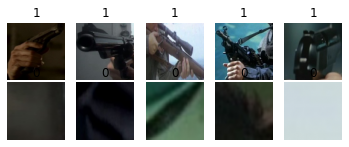

In [4]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 5

# Select the first N positive examples
positive_example_indices = (Y_train == 1)
positive_examples = X_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# Select the first N negative examples
negative_example_indices = (Y_train == 0)
negative_examples = X_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

visualize_data(positive_examples, negative_examples)

### Define Model (CNN)

* Experimented with different layers, neurons, and layers
* Current version works best

In [5]:
N_LAYERS = 3

def CNN_Model(size, n_layers):
    # Define CNN hyperparamters
    MIN_NEURONS = 1
    MAX_NEURONS = 4
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        # Create initial input layer
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    # Add linear output layer with Sigmoid Activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile CNN with loss, optimizer, and accuracy metric
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [6]:
model = CNN_Model(size = image_size, n_layers = N_LAYERS)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 1)         28        
_________________________________________________________________
activation (Activation)      (None, 94, 94, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 2)         20        
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 3)         57        
_________________________________________________________________
activation_2 (Activation)    (None, 90, 90, 3)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 3)         0

### Train Model
**Hyperparameters**
* Epoch Count = 50
* Batch Size = 100

Both hyperparameters were experimented with & determined to be such

In [7]:
EPOCHS = 50
BATCH_SIZE = 100

In [8]:
# Train the model - Each epoch value can be seen below
history = model.fit(X_train, Y_train, 
          epochs = EPOCHS,
          batch_size = BATCH_SIZE)

Epoch 1/50
192/192 [==============================] - 69s 349ms/step - loss: 0.5753 - accuracy: 0.7895
Epoch 2/50
192/192 [==============================] - 66s 345ms/step - loss: 0.5068 - accuracy: 0.7963
Epoch 3/50
192/192 [==============================] - 66s 346ms/step - loss: 0.5059 - accuracy: 0.7965
Epoch 4/50
192/192 [==============================] - 66s 344ms/step - loss: 0.5054 - accuracy: 0.7968
Epoch 5/50
192/192 [==============================] - 65s 340ms/step - loss: 0.5023 - accuracy: 0.7991
Epoch 6/50
192/192 [==============================] - 66s 343ms/step - loss: 0.5026 - accuracy: 0.7993
Epoch 7/50
192/192 [==============================] - 66s 344ms/step - loss: 0.5128 - accuracy: 0.7911
Epoch 8/50
192/192 [==============================] - 66s 342ms/step - loss: 0.4969 - accuracy: 0.8032
Epoch 9/50
192/192 [==============================] - 66s 341ms/step - loss: 0.3932 - accuracy: 0.8206
Epoch 10/50
192/192 [==============================] - 66s 346ms/step - l

### Display Results (NN Learning Curves)
* Training Accuracy
* Training Loss

In [15]:
hist_df = pd.DataFrame(history.history)
hist_df['accuracy'] = hist_df['accuracy'] * 100
hist_df

,loss,accuracy
0,0.529142,79.559076
1,0.505777,79.699796
2,0.505255,79.699796
3,0.505121,79.699796
4,0.505429,79.699796
5,0.505907,79.699796
6,0.504891,79.699796
7,0.505421,79.699796
8,0.308622,85.537082
9,0.221297,90.316361


### Plot Training Accuracy

Highest Training Accuracy: 97.88398146629333


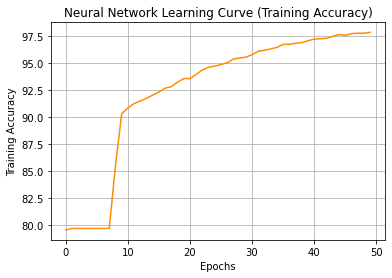

In [23]:
print('Highest Training Accuracy: {}'.format(hist_df['accuracy'].max()))

hist_df['accuracy'].plot(color = 'darkorange')

plt.grid()
# plt.ylim(0, 100, 10)
plt.title('Neural Network Learning Curve (Training Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()

### Plot Training Loss

Minimum Training Loss: 0.06477593630552292


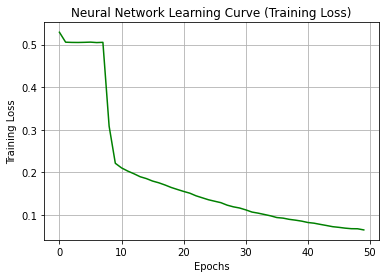

In [18]:
print('Minimum Training Loss: {}'.format(hist_df['loss'].min()))

hist_df['loss'].plot(color = 'green')

plt.grid()
plt.title('Neural Network Learning Curve (Training Loss)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

### Evaluate the Model based on Predicting Dataset

In [21]:
pred = model.predict(X_test)
pred = np.round(pred)

# Report the predictive accuracy
accuracy = accuracy_score(Y_test, pred)
print("Predictive Accuracy:", str(accuracy), '\n')

Predictive Accuracy: 0.8907129455909943 



### Evaluate Predictive Accuracy by Class

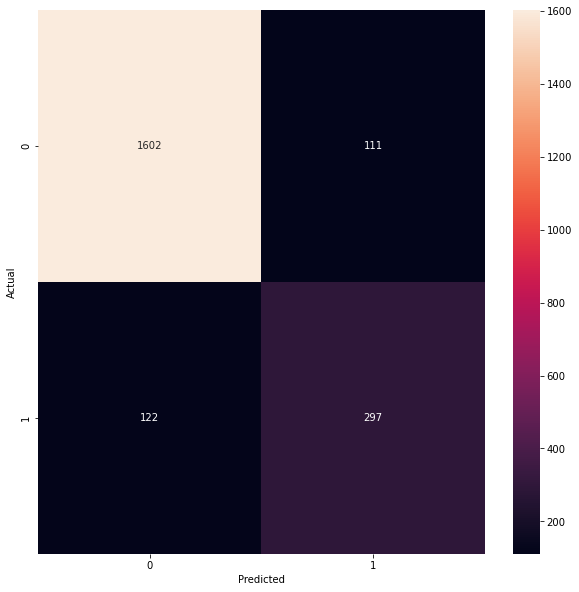

In [19]:
# Create Confusion Matrix to Determine Class Accuracy
conf_mat = confusion_matrix(pred, Y_test)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
# Convert Confusion Matrix Data to Array
conf = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]
conf

array([[0.9352014 , 0.0647986 ],
       [0.29116945, 0.70883055]])

### Convert Confusion Matrix Values to DataFrame for Evaluation

In [13]:
# Create DataFrame from Confusion Matrix Array
df = pd.DataFrame(np.unique(Y_test))
df['Class Accuracies (%)'] = np.round(conf.diagonal() * 100, 1)
df = df.reset_index(drop = True)
df.columns = ['Class', 'Class Accuracies (%)']

In [14]:
df

,Class,Class Accuracies (%)
0,0.0,93.5
1,1.0,70.9
